

# Assignment 1
---

# Students

Bernie Howard- 203039417


Igor Alikin- 322081241

Dor Carmi- 205789662

# Graphs and utilities

In [ ]:
import random
import itertools
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from typing import Dict, List
from termcolor import cprint
from pathlib import Path
from scipy.io import loadmat
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [ ]:
seed = 1920
np.random.seed(seed=seed)


def plot_semilogy(lines: List, title=None):
    plt.semilogy(lines[0][1:])
    plt.semilogy(lines[1][1:])
    plt.legend(("Zero order approx", "First order approx"))
    if not title:
      plt.title("Successful Grad test in semilogarithmic plot")  # TODO: title
    else:
      plt.title(title)
    plt.xlabel("k")
    plt.ylabel("error")
    plt.show()


def test_dummy_data(samples=20, iter=10, eps=0.1, f=lambda x: 0.5 * np.dot(x, x), g_f=lambda x: x):
    x = np.random.randn(samples)
    d = np.random.randn(samples)
    f0 = f(x)
    g0 = g_f(x)
    y0, y1 = np.zeros(iter), np.zeros(iter)
    cprint("k\t error order 1 \t\t\t error order 2", 'green')
    for k in range(iter):
        epsk = eps * (0.5 ** k)
        fk = f(x + epsk * d)
        f1 = f0 + epsk * np.dot(g0, d)
        y0[k] = abs(fk - f0)
        y1[k] = abs(fk - f1)
        print(k, "\t", abs(fk - f0), "\t", abs(fk - f1))
    plot_semilogy([y0, y1])


def plot_classification_accuracy(train, val):
    plt.plot(train)
    plt.plot(val)
    plt.legend(("train acc", "validation acc"))
    plt.title("Train and validation accuracy per epoch")
    plt.xlabel("epoch")
    plt.ylabel("accuracy")
    plt.show()


def plot_loss(loss):
    plt.plot(loss)
    plt.legend(("l"))  # For some reason there's a bug, and it plots "v" instead of "validation loss" so we changed it to l....
    plt.title("Validation loss per epoch")
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.show()

In [ ]:
def load_datasets(folder):
    return {Path(f).stem: loadmat(f) for f in glob.glob(folder)}


def print_metrics(epoch, loss, train_acc, val_acc):
    print(f'epoch {epoch + 1}: validation loss = {loss}')
    print(f'end of epoch {epoch + 1}, train acc. = {train_acc}')
    print(f'end of epoch {epoch + 1}, val acc. = {val_acc}')


datasets = load_datasets('*.mat')

In [ ]:
def ls_mini_batch_generator(data, bs, shuffle=False):
    data_len = len(data)
    if shuffle:
        data.sample(frac=1)
    n_batches = data_len // bs
    for i in range(n_batches):
        try:
            yield pd.DataFrame([data['x'][bs * i:bs * (i + 1)], data['b'][bs * i:bs * (i + 1)]]).T, data['y'][bs * i:bs * (i + 1)]
        except (KeyError, ValueError) as e:
            print(f'{e}')


def data_mini_batch_generator(data, bs, shuffle=True):
    X, y = data
    data_len = len(X)
    if shuffle:
        order = random.sample([i for i in range(data_len)], data_len)
        X, y = X[order], y[order]
    n_batches = data_len // bs
    for i in range(n_batches):
        try:
            yield X[bs * i:bs * (i + 1)].T, y[bs * i:bs * (i + 1)].T
        except (KeyError, ValueError) as e:
            print(f'{e}')

In [ ]:
def relu(x):
    return np.maximum(0, x)


def relu_derivative(z):
    return np.greater(z, 0).astype(int)


def tanh_derivative(z):
    return 1 - np.tanh(z) ** 2


# 2.1 Part I: the classifier and optimizer

### 2.1.1. Write the code for computing the loss function "soft-max regression" and its gradient with respect to wj and the biases. Make sure that the derivatives are correct using the gradient test (See the subsection "Gradient and Jacobian Verification" in the notes). You should demonstrate and submit the results of the gradient test.

In [ ]:
def softmax(Z) -> np.ndarray:
    """
    :param Z: input matrix
    :return: softmax on matrix input
    """
    mat = np.exp(Z - np.max(Z))
    mat = mat / np.sum(mat, axis=0)
    return mat


def softmax_loss(x: np.ndarray, c) -> np.ndarray:
    """

    :param x: xtw inputs after softmax
    :param c: one-hot encoding matrix
    :return: softmax loss on data
    """
    if len(x.shape) > 1:
        m = x.shape[1]
    else:
        m = x.shape
    return -(1 / m) * np.sum(np.log(x) * c)


def grad_softmax_loss_wrt_w(mat, x: np.ndarray, c: np.ndarray):
    """
    Function that returns the gradient on the softmax w.r.t weights
    :param x: input data
    :param c: one-hot class matrix
    :param mat: wxb after softmax
    :return: gradient of softmax loss w.r.t weights
    """
    m = c.shape[1]
    return (1 / m) * (mat - c) @ x.T


def grad_softmax_wrt_b(z, c: np.ndarray):
    """
    Function that returns the gradient on the softmax w.r.t bias
    :param z: matrix after softmax
    :param c: one-hot class matrix
    :param mat: wxb after softmax
    :return: gradient of softmax loss  w.r.t bias
    """
    # as seen in https://cs231n.github.io/neural-networks-case-study/
    m = c.shape[1]
    return (1 / m) * (z - c)


def grad_softmax_wrt_x(z, w, c: np.ndarray):
    """
    Function that returns the gradient on the softmax w.r.t input
    :param z: matrix after softmax
    :param c: one-hot class matrix
    :param w: layer weights
    :return: gradient of softmax loss  w.r.t input
    """
    m = c.shape[1]
    return (1 / m) * w.T @ (z - c)

In [ ]:
def test_grad_softmax(inputs, w, bias, one_hot_classes, iters=10, eps=0.1):
    d = np.random.rand(one_hot_classes.shape[0], inputs.shape[0])
    db = np.random.rand(one_hot_classes.shape[0], 1)
    Z = w @ inputs + bias
    sm_wxb = softmax(Z)
    f0 = softmax_loss(sm_wxb, one_hot_classes)
    g0 = grad_softmax_loss_wrt_w(x=inputs, mat=sm_wxb, c=one_hot_classes)
    g0_b = grad_softmax_wrt_b(z=sm_wxb, c=one_hot_classes)
    y0, y1 = np.zeros(iters), np.zeros(iters)
    df = pd.DataFrame(columns=["Error order 1", "Error order 2"])
    cprint("k\t error order 1 \t\t\t error order 2", 'green')
    for k in range(iters):
        epsk = eps * (0.5 ** k)
        A = (w + epsk * d) @ inputs + (bias + epsk * db)
        fk = softmax_loss(softmax(A), one_hot_classes)
        y0[k] = np.abs(fk - f0)
        y1[k] = np.abs(fk - f0 - epsk * np.sum(g0 * d) - epsk * np.sum(g0_b * db))
        print(k, "\t", y0[k], "\t", y1[k])
        s = pd.Series([y0[k], y1[k]], index=df.columns.to_list())
        df = df.append(s, ignore_index=True)
    df.astype('string').to_csv('error_by_orders.csv')
    plot_semilogy([y0, y1])

l2 norm of x is 4.045911446267979
l2 norm of w is 0.9999999999999999
l2 norm of bias is 1.0
k	 error order 1 			 error order 2
0 	 0.01614442707717656 	 0.00027894058505318546
1 	 0.00800269027238043 	 6.994702631874342e-05
2 	 0.003983884459367815 	 1.751283633697111e-05
3 	 0.0019875672547455814 	 4.381443230159607e-06
4 	 0.0009926886692041004 	 1.0957634463894847e-06
5 	 0.0004960704439680441 	 2.7399108918867364e-07
6 	 0.00024796673048377293 	 6.850404434521306e-08
7 	 0.00012396624001453915 	 1.7126794825292165e-08
8 	 6.197883840652896e-05 	 4.281796672027297e-09
9 	 3.09883487663587e-05 	 1.070461430232413e-09


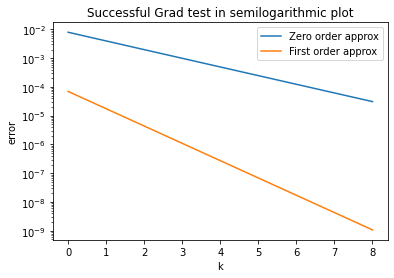

In [ ]:
def run_test_grad_softmax():
    np.random.seed(seed=seed)

    n, m = 6, 3
    classes = 2

    X = np.random.randn(n, m)
    w = np.random.randn(classes, n)
    w = w / np.linalg.norm(w)
    bias = np.random.rand(w.shape[0], 1)
    bias = bias / np.linalg.norm(bias)

    print(f'l2 norm of x is {np.linalg.norm(X)}')
    print(f'l2 norm of w is {np.linalg.norm(w)}')
    print(f'l2 norm of bias is {np.linalg.norm(bias)}')
    y_vals = np.random.randint(low=0, high=classes, size=m)

    one_hot = np.eye(classes)[y_vals].T

    test_grad_softmax(X, w, bias, one_hot)

run_test_grad_softmax()

### 2.1.2 Write the code for minimizing an objective function using SGD or some other SGD variant (SGD with momentum, for example). Demonstrate and verify that your optimizer works on a small least squares example (add plots and submit the code itself).

In [ ]:
seed = 1923
np.random.seed(seed)
random.seed(seed)

def generate_numbers(a, b, n):
    nums = [np.random.rand() * np.random.randint(-1, 2) for _ in range(n)]
    epsilons = [np.random.rand() * np.random.randint(-1, 2) for _ in range(n)]
    return pd.DataFrame([(x, a * x + eps, b + eps, a * x + eps + b) for (x, eps) in zip(nums, epsilons)],
                        columns=['x', 'ax', 'b', 'y'])


def ls_gradient(x, w, y):
    return ((x @ w) - y).T @ x


def calc_sgd(data, epochs=1250, batch_size=32, lr=0.05, threshold=0.001):
    w = np.random.rand(data.drop(['x', 'y'], axis=1).shape[1])
    w = w / np.linalg.norm(w)
    for i in range(epochs):
        print(f'Starting epoch {i + 1}/{epochs}')
        generator = ls_mini_batch_generator(data=data, bs=batch_size, shuffle=True)
        for mb in range(data.shape[0] // batch_size):
            X, y = next(generator)
            w = w - lr * ((1 / X.shape[0]) * ls_gradient(X, w, y))
            loss = (1 / (2 * batch_size)) * np.linalg.norm((X @ w) - y) ** 2
            if not mb % 50:
                print(f'{i + 1}/{mb} - weights = {np.array(w)}, loss = {loss}')
            if loss < threshold:
                print(f'{i}/{mb} - finished. weights = {np.array(w)}, loss = {loss}')
                return w
    return w

In [ ]:
def ls_data_example(numbers,weights):
    SHOW_PLOTS = True
    reg = LinearRegression().fit(numbers[['x']], numbers[['y']])
    plt.scatter(numbers['x'], numbers['y'])
    print(f'linear regression coeffs by sklearn are: {reg.coef_[0][0]}, {reg.intercept_[0]}')
    x = np.linspace(-1, 1, 100)
    y = x * a + b
    y2=x*weights[0]+weights[1]*b
    label = f'x * {a} + {b}'
    plt.plot(x, y, '-r', label=label)
    plt.plot(x, y2, '--g', label="SGD regressed Least squares")
    plt.legend()
    plt.xlabel("x")
    plt.ylabel(f"{a}x + {b}")
    plt.title(f'Graph of {label}')
    if SHOW_PLOTS:
        plt.show()

In [ ]:
def run_ls_example(a, b, bs):
    numbers = generate_numbers(a=a, b=b, n=bs * 200)
    best_weights = calc_sgd(numbers, batch_size=bs, threshold=5e-5)
    ls_data_example(numbers,best_weights)
    

Starting epoch 1/1250
1/0 - weights = [0.93882491 0.8257909 ], loss = 25.297402959756845
1/50 - weights = [7.3021221  1.01084912], loss = 8.114123234350455
1/100 - weights = [11.02832568  0.9752061 ], loss = 2.5493626750216634
1/150 - weights = [13.17144157  0.99037524], loss = 0.7376145711213815
Starting epoch 2/1250
2/0 - weights = [14.3792257   0.98865794], loss = 0.29289929376066054
2/50 - weights = [15.06396269  1.00116755], loss = 0.09397261309052861
2/100 - weights = [15.46496459  0.99733176], loss = 0.029525096596148163
2/150 - weights = [15.69559975  0.99896421], loss = 0.008542582691927062
Starting epoch 3/1250
3/0 - weights = [15.82557755  0.9987794 ], loss = 0.003392173277642092
3/50 - weights = [15.89926671  1.00012565], loss = 0.00108833101938562
3/100 - weights = [15.94242123  0.99971285], loss = 0.0003419408848936579
3/150 - weights = [15.96724144  0.99988853], loss = 9.893475794201494e-05
2/183 - finished. weights = [15.9773776   1.00007508], loss = 4.7387277619572884e

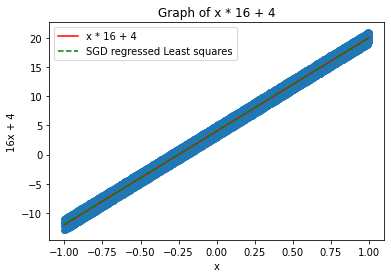

In [ ]:
a, b = 16, 4
bs = 256
run_ls_example(a, b, bs)

### 2.1.3. Demonstrate the minimization of the softmax function using your SGD variant. Plot a graph of the success percentages of the data classification after each epoch|for both the training data and the validation data. For the plots, you may only use a random subsample of the two data sets (instead of each time computing the loss for the whole data) as these are extra computations that are not related to the optimization itself.

In [ ]:
def calc_classification(data, epochs=20, batch_size=32, lr=0.5, threshold=1e-6):
    X_train, X_val, y_train, y_val = data['Yt'].T, data['Yv'].T, data['Ct'].T, data['Cv'].T
    w = np.random.rand(y_val.shape[1], X_train.shape[1])
    w = w / np.linalg.norm(w)
    metrics = dict()
    for epoch in range(epochs):
        train_gen = data_mini_batch_generator(data=[X_train, y_train], bs=batch_size)
        for mb in range(X_train.shape[0] // batch_size):
            X_batch, y_batch = next(train_gen)
            sm = softmax(w @ X_batch)
            g = grad_softmax_loss_wrt_w(x=X_batch, mat=sm, c=y_batch)
            gb = grad_softmax_wrt_b(z=sm, c=y_batch)
            w = w - lr * g
        train_softmax = softmax(w @ X_train.T)
        val_softmax = softmax(w @ X_val.T)
        loss = softmax_loss(val_softmax, y_val.T)

        train_pred, train_truth = np.eye(y_train.shape[1])[np.argmax(train_softmax, axis=0)].T, y_train.T
        train_acc = np.count_nonzero(np.all(train_pred == train_truth, axis=0)) / train_truth.shape[1]
        val_pred, val_truth = np.eye(y_val.shape[1])[np.argmax(val_softmax, axis=0)].T, y_val.T
        val_acc = np.count_nonzero(np.all(val_pred == val_truth, axis=0)) / val_truth.shape[1]
        metrics[epoch] = [train_acc, val_acc, loss]
    plot_classification_accuracy([m[0] for m in metrics.values()], [m[1] for m in metrics.values()])
    plot_loss([m[2] for m in metrics.values()])

Trying different ls and lr combinations to see if there's a difference in results

testing with lr = 0.05 and bs = 32


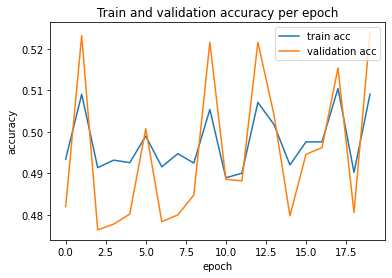

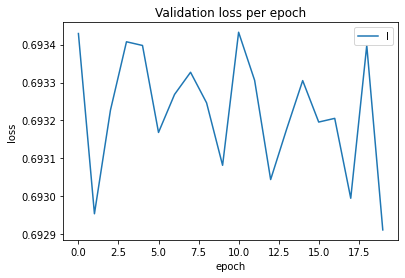

testing with lr = 0.05 and bs = 128


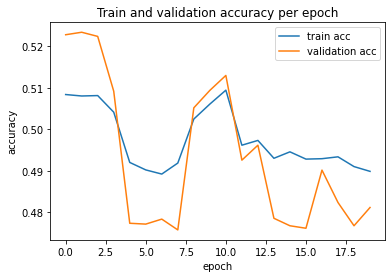

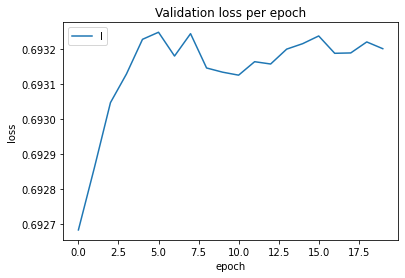

testing with lr = 0.01 and bs = 32


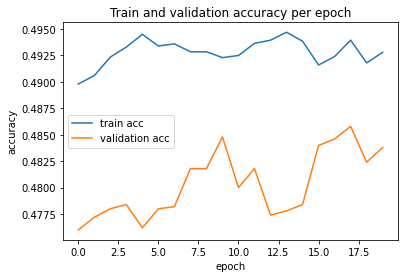

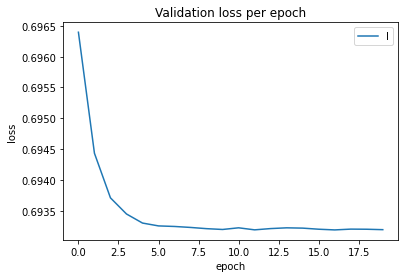

testing with lr = 0.01 and bs = 128


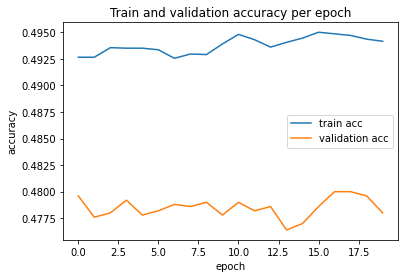

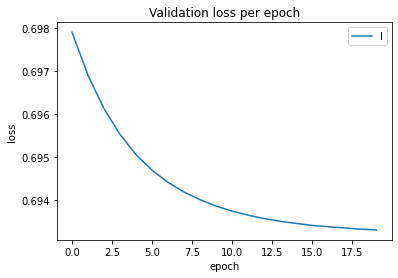

testing with lr = 0.005 and bs = 32


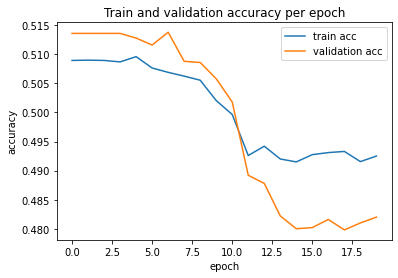

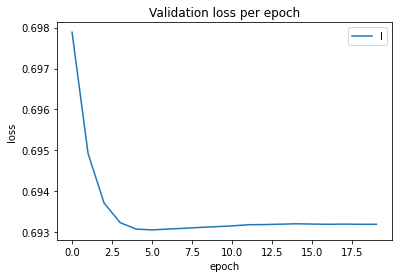

testing with lr = 0.005 and bs = 128


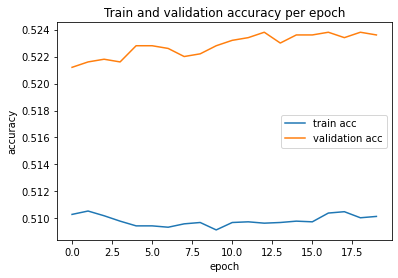

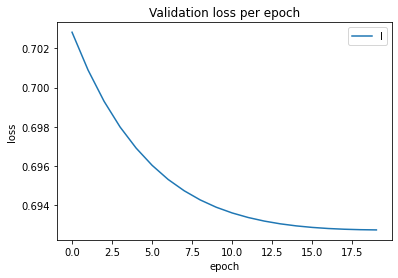

In [ ]:
lrs = [0.01 * a for a in [5, 1, 0.5]]
bs = [32, 128]
combinations = itertools.product(lrs, bs)
for lr, bs in combinations:
    cprint(f'testing with lr = {lr} and bs = {bs}', 'red')
    calc_classification(datasets['SwissRollData'], lr=lr, batch_size=bs)

# 2.2 Part II: the neural network

### 2.2.1. Write the code for the standard neural network. Including the forward pass and backward pass (the computation of the "Jacobian transpose times vector"). See that the Jacobian tests work and submit the tests (using plots, as demonstrated in the course notes). This part should not be overlooked. Remark: for the Jacobian tests use the tanh() activation function, as it is diferentiable and will behave properly in the gradient tests. The ReLU function is piecewise linear and non-smooth and may lead to weird-looking gradient tests. After the gradient test passes, you may use either activation functions in the network.

In [ ]:
def relu(x):
    return np.maximum(0, x)

def relu_derivative(z):
    return np.greater(z, 0).astype(int)

def tanh_derivative(z):
    return 1 - np.tanh(z) ** 2

In [ ]:
def jacobian_function(w, x, b):
    z = w @ x + b
    return np.tanh(z)


def jacobian_gradients(w, x, b, v):
    z = w @ x + b
    a = (tanh_derivative(z) * v)
    # dx, dw, db
    return w.T @ a, a @ x.T, a.sum(keepdims=True, axis=1)


def jacobian_function_resnet(w, w2, x, b):
    z = w @ x + b
    return x + (w2 @ np.tanh(z))


def jacobian_gradients_resnet(w, w2, x, b, v):
    z = w @ x + b
    deriv = tanh_derivative(z)
    a = deriv * (w2.T @ v)

    # dx, dw, dw2, db
    return v + w.T @ a, a @ x.T, v @ np.tanh(z).T, a.sum(keepdims=True, axis=1)

In [ ]:
def test_jacobian(x, w, b, v, w2=None, eps=0.1, iters=10):
    resnet = False
    if np.any(w2):
        resnet = True
    dx = np.random.rand(x.shape[0], x.shape[1])
    dw = np.random.rand(w.shape[0], w.shape[1])
    db = np.random.rand(b.shape[0], b.shape[1])
    if resnet:
        dw2 = np.random.rand(w2.shape[0], w2.shape[1])

    # compute g0 and grads
    if not resnet:
        g0 = np.vdot(jacobian_function(w, x, b), v)
        grad_x, grad_w, grad_b = jacobian_gradients(w, x, b, v)
    else:
        g0 = np.vdot(jacobian_function_resnet(w, w2, x, b), v)
        grad_x, grad_w, grad_w2, grad_b = jacobian_gradients_resnet(w, w2, x, b, v)

    y0_b, y1_b = np.zeros(iters), np.zeros(iters)
    y0_w, y1_w = np.zeros(iters), np.zeros(iters)
    y0_x, y1_x = np.zeros(iters), np.zeros(iters)
    y0_w2, y1_w2 = np.zeros(iters), np.zeros(iters)
    df = pd.DataFrame(columns=["Error order 1", "Error order 2"])
    for k in range(iters):
        epsk = eps * (0.5 ** k)
        if not resnet:
            gk_w = np.vdot(jacobian_function(w + epsk * dw, x, b), v)
            gk_x = np.vdot(jacobian_function(w, x + epsk * dx, b), v)
            gk_b = np.vdot(jacobian_function(w, x, b + epsk * db), v)
        else:
            gk_w = np.vdot(jacobian_function_resnet(w + epsk * dw, w2, x, b), v)
            gk_x = np.vdot(jacobian_function_resnet(w, w2, x + epsk * dx, b), v)
            gk_b = np.vdot(jacobian_function_resnet(w, w2, x, b + epsk * db), v)
            gk_w2 = np.vdot(jacobian_function_resnet(w, w2 + epsk * dw2, x, b), v)
        y0_b[k] = np.abs(gk_b - g0)
        y1_b[k] = np.abs(gk_b - g0 - np.vdot(grad_b, epsk * db))
        y0_x[k] = np.abs(gk_x - g0)
        y1_x[k] = np.abs(gk_x - g0 - np.vdot(grad_x, epsk * dx))
        y0_w[k] = np.abs(gk_w - g0)
        y1_w[k] = np.abs(gk_w - g0 - np.vdot(grad_w, epsk * dw))
        if resnet:
            y0_w2[k] = np.abs(gk_w2 - g0)
            y1_w2[k] = np.abs(gk_w2 - g0 - np.vdot(grad_w2, epsk * dw2))
    cprint('print semilogarithmic graph for b jacobian', 'green')
    plot_semilogy([y0_b, y1_b], title = "semilogarithmic graph for b jacobian")
    cprint('print semilogarithmic graph for x jacobian', 'green')
    plot_semilogy([y0_x, y1_x], title = "semilogarithmic graph for x jacobian")
    cprint('print semilogarithmic graph for w jacobian', 'green')
    plot_semilogy([y0_w, y1_w], title = "semilogarithmic graph for w jacobian")
    if resnet:
      cprint('print semilogarithmic graph for w2 jacobian', 'green')
      plot_semilogy([y0_w2, y1_w2], title = 'semilogarithmic graph for w2 jacobian')

In [ ]:
def test_resnet_jacobian():
    n, m = 8, 32

    x = np.random.randn(n, m)
    w = np.random.randn(n, n)
    b = np.random.rand(w.shape[0], 1)
    v = np.random.rand(n, m)
    w2 = np.random.randn(n, n)

    w = w / np.linalg.norm(w)
    b = b / np.linalg.norm(b)
    v = v / np.linalg.norm(v)
    w2 = w2 / np.linalg.norm(w2)

    test_jacobian(x, w, b, v, w2=w2)


def test_regular_nn_jacobian():
    n, m = 8, 32
    n2 = 4

    x = np.random.randn(n, m)
    w = np.random.randn(n2, n)
    w = w / np.linalg.norm(w)
    b = np.random.rand(w.shape[0], 1)
    b = b / np.linalg.norm(w)
    v = np.random.rand(n2, m)
    v = v / np.linalg.norm(v)

    test_jacobian(x, w, b, v)


print semilogarithmic graph for b jacobian


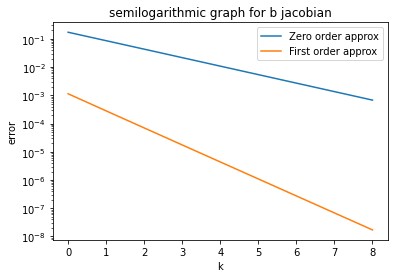

print semilogarithmic graph for x jacobian


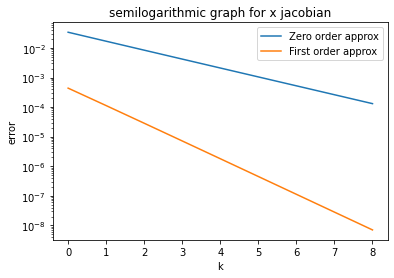

print semilogarithmic graph for w jacobian


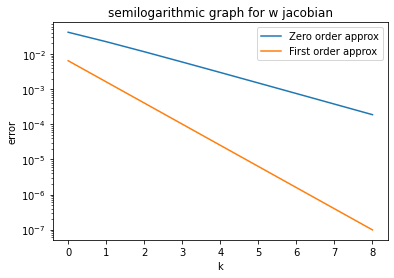

In [ ]:
test_regular_nn_jacobian()

In [ ]:
class Layer:
    def __init__(self, layer_id, input_dim, output_dim, activation, lr, is_resnet_layer=False):
        self.activation_type = activation
        self.layer_id = layer_id
        self.w = np.random.randn(output_dim, input_dim)
        self.b = np.random.randn(output_dim, 1)
        self.activation = self.__get_activation(activation)
        self.activation_grad = self.__get_activation_derivative(activation)
        if self.activation_type != 'softmax' and self.layer_id != 0:
            self.is_resnet_layer = is_resnet_layer
        else:
            self.is_resnet_layer = False
        self.lr = lr
        self.v = None
        self.z = None
        self.x = None
        if self.is_resnet_layer:
            self.w2 = np.random.randn(input_dim, output_dim)

    @staticmethod
    def __get_activation_derivative(activation):
        activation = activation.lower()
        if activation == 'relu':
            return relu_derivative
        elif activation == 'softmax':
            return grad_softmax_wrt_x
        elif activation == 'tanh':
            return tanh_derivative
        raise ValueError('Unknown activation func')

    @staticmethod
    def __get_activation(activation):
        activation = activation.lower()
        if activation == 'relu':
            return relu
        elif activation == 'softmax':
            return softmax
        elif activation == 'tanh':
            return np.tanh
        raise ValueError('Unknown activation func')

    def forward(self, x):
        self.v = self.w @ x + self.b
        self.x = x
        if not self.activation_type == 'softmax':
            self.grad = self.activation_grad(self.v)
        self.z = self.activation(self.v)
        if self.is_resnet_layer:
            self.z = x + (self.w2 @ self.z)
        return self.z

    def backward(self, dx):
        deriv = self.activation_grad(self.v)
        if not self.is_resnet_layer:
            a = deriv * dx
            self.db = a.sum(keepdims=True, axis=1)
            self.dw = a @ self.x.T
            dx = self.w.T @ a
            return dx
        else:
            a = deriv * (self.w2.T @ dx)
            self.dw = a @ self.x.T
            self.dw2 = dx @ self.activation(self.v).T
            self.db = a.sum(keepdims=True, axis=1)
            dx = dx + self.w.T @ a
            return dx

    def update_weights(self):
        bs = self.z.shape[1]
        if self.activation_type != 'softmax':
            a = 1 / bs
        else:
            a = 1
        self.w = self.w - self.lr * a * self.dw
        self.b = self.b - self.lr * a * self.db

        if self.is_resnet_layer:
            self.w2 = self.w2 - self.lr * a * self.dw2


class Model:
    def __init__(self, layer_dict: List[Dict], is_resnet=False, seed=66, lr=0.001, epochs=30, batch_size=32):
        np.random.seed(seed)
        self.L = len(layer_dict)
        self.lr = lr
        self.batch_size = batch_size
        self.epochs = epochs
        self.layers = dict()
        self.__init_layers(layer_dict, is_resnet)
        self.__print_model()

    def get_layers(self):
        return self.layers

    def __print_model(self):
        for name, layer in self.layers.items():
            print(f'{name}: w: {layer.w.shape}, b:{layer.b.shape}')

    def __init_layers(self, layer_dict, is_resnet):
        for i, layer in enumerate(layer_dict):
            self.layers[f'layer_{i}'] = Layer(i, layer['input_dim'], layer['output_dim'], layer['activation'],
                                              lr=self.lr, is_resnet_layer=is_resnet)

    def forward(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)
        return x

    def _update_softmax_layer(self, reversed_layers, prediction, y):
        last_layer = reversed_layers[0]
        w, x, b = last_layer.w, last_layer.x, last_layer.b
        dw = grad_softmax_loss_wrt_w(prediction, x, y)
        db = grad_softmax_wrt_b(prediction, y)
        dx = grad_softmax_wrt_x(prediction, w, y)
        # last_layer.w = last_layer.w - self.lr * dw
        last_layer.dw = dw
        db = np.sum(db, axis=1, keepdims=True)
        # db = np.expand_dims(np.ones(last_layer.b.shape[0]), axis=1)
        last_layer.db = db
        # last_layer.b = last_layer.b - self.lr * db
        return dx


    def backward(self, prediction, y):
        reversed_layers = list(self.layers.values())[::-1]
        dx = self._update_softmax_layer(reversed_layers, prediction, y)
        for curr_layer in reversed_layers[1:]:
            dx = curr_layer.backward(dx)

    def update_weights(self):
        for n, layer in list(self.get_layers().items()):
            layer.update_weights()

    @staticmethod
    def plot_metrics(metrics):
        plot_classification_accuracy([m[0] for m in metrics.values()], [m[1] for m in metrics.values()])
        plot_loss([m[2] for m in metrics.values()])

    def compute_acc(self, pred, y):
        pred = np.eye(y.shape[1])[np.argmax(pred, axis=0)].T
        return np.count_nonzero(np.all(pred == y.T, axis=0)) / y.shape[0]

    def compute_loss(self, pred, y):
        return softmax_loss(pred, y)

    def train(self, data):
        X_train, X_val, y_train, y_val = data
        metrics = dict()
        for i in range(self.epochs):
            train_gen = data_mini_batch_generator(data=[X_train, y_train], bs=self.batch_size, shuffle=True)
            train_gen = [x for x in train_gen]
            # print(f'Starting epoch {i+1}/{self.epochs}')
            for mb in range(X_train.shape[0] // self.batch_size):
                X, y = train_gen[mb]
                out = self.forward(X)
                self.backward(out, y)
                self.update_weights()
            acc_train = self.compute_acc(self.forward(X_train.T), y_train)
            acc_val = self.compute_acc(self.forward(X_val.T), y_val)
            train_loss = self.compute_loss(self.forward(X_train.T), y_train.T)
            val_loss = self.compute_loss(self.forward(X_val.T), y_val.T)
            if not i % 25:
                print(f'epoch {i + 1}: acc_train = {acc_train}, acc_val = {acc_val}, loss_val = {val_loss}, train_loss = {train_loss}')
            metrics[i] = [acc_train, acc_val, val_loss]
        Model.plot_metrics(metrics)

In [ ]:
def create_arch(name, resnet):
  data = datasets[name]
  all_data = (data['Yt'].T, data['Yv'].T, data['Ct'].T, data['Cv'].T)
  input_shape = data['Yt'].shape[0]
  output_shape = data['Ct'].shape[0]
  if not resnet:
    arch = [
        {"input_dim": input_shape, "output_dim": 8, "activation": "relu"},
        {"input_dim": 8, "output_dim": 9, "activation": "relu"},
        {"input_dim": 9, "output_dim": output_shape, "activation": "softmax"},
    ]
  else:
    arch = [
        {"input_dim": input_shape, "output_dim": 15, "activation": "relu"},
        {"input_dim": 15, "output_dim": 15, "activation": "relu"},
        {"input_dim": 15, "output_dim": output_shape, "activation": "softmax"},
    ]
  return arch, all_data

Training on: SwissRollData
layer_0: w: (8, 2), b:(8, 1)
layer_1: w: (9, 8), b:(9, 1)
layer_2: w: (2, 9), b:(2, 1)
epoch 1: acc_train = 0.63105, acc_val = 0.6328, loss_val = 0.6169227252955025, train_loss = 0.6214682145019854
epoch 26: acc_train = 0.79115, acc_val = 0.7954, loss_val = 0.46822756774778745, train_loss = 0.4685698729912166
epoch 51: acc_train = 0.79505, acc_val = 0.796, loss_val = 0.4021768912740169, train_loss = 0.3993784729204138
epoch 76: acc_train = 0.8278, acc_val = 0.8294, loss_val = 0.3771646952618576, train_loss = 0.3654804355923672
epoch 101: acc_train = 0.8316, acc_val = 0.8318, loss_val = 0.34118478061238583, train_loss = 0.32461669255322195


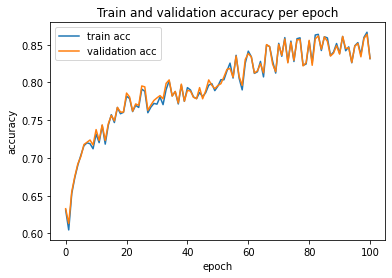

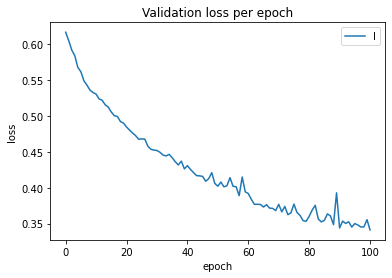

In [ ]:
dataset_name = 'SwissRollData'
print(f'Training on: {dataset_name}')
arch, all_data = create_arch(dataset_name, False)
model = Model(layer_dict=arch, batch_size=32, epochs=101, lr=0.1, is_resnet=False)
model.train(all_data)

Training on: SwissRollData
layer_0: w: (8, 5), b:(8, 1)
layer_1: w: (9, 8), b:(9, 1)
layer_2: w: (5, 9), b:(5, 1)
epoch 1: acc_train = 0.62052, acc_val = 0.62224, loss_val = 0.932424227347407, train_loss = 0.9380699657685034
epoch 26: acc_train = 0.93272, acc_val = 0.9296, loss_val = 0.29391645891794443, train_loss = 0.29549561466166124
epoch 51: acc_train = 0.94392, acc_val = 0.9424, loss_val = 0.2595784066571243, train_loss = 0.2624080889719904
epoch 76: acc_train = 0.94636, acc_val = 0.94624, loss_val = 0.24767319262450244, train_loss = 0.2494204131155825
epoch 101: acc_train = 0.94992, acc_val = 0.9496, loss_val = 0.2374273642477592, train_loss = 0.23770075446087513


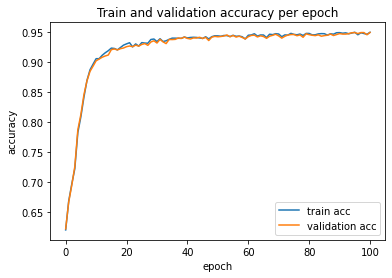

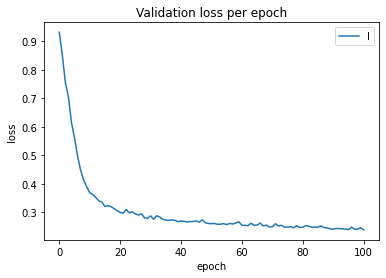

In [ ]:
name = 'GMMData'
print(f'Training on: {dataset_name}')
arch, all_data = create_arch(name, False)
model = Model(layer_dict=arch, batch_size=32, epochs=101, lr=0.1, is_resnet=False)
model.train(all_data)

Training on: PeaksData
layer_0: w: (8, 2), b:(8, 1)
layer_1: w: (9, 8), b:(9, 1)
layer_2: w: (5, 9), b:(5, 1)
epoch 1: acc_train = 0.7768, acc_val = 0.77648, loss_val = 0.6955238514920538, train_loss = 0.6814712307779168
epoch 26: acc_train = 0.88112, acc_val = 0.87904, loss_val = 0.41936186263889846, train_loss = 0.40066226827458357
epoch 51: acc_train = 0.9048, acc_val = 0.896, loss_val = 0.3700269399885245, train_loss = 0.3471545411368989
epoch 76: acc_train = 0.91196, acc_val = 0.90496, loss_val = 0.35424593254460957, train_loss = 0.3337747650584592
epoch 101: acc_train = 0.91396, acc_val = 0.90848, loss_val = 0.3417884384848826, train_loss = 0.32427184494349753


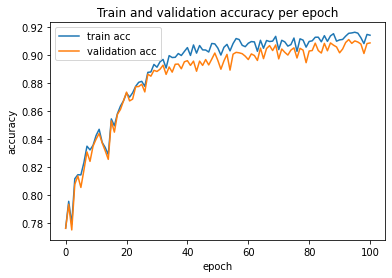

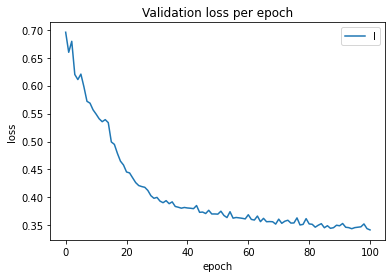

In [ ]:
name = 'PeaksData'
print(f'Training on: {name}')
arch, all_data = create_arch(name, False)
model = Model(layer_dict=arch, batch_size=32, epochs=101, lr=0.1, is_resnet=False)
model.train(all_data)

### 2.2.2. Repeat the previous section for the residual neural *network*

print semilogarithmic graph for b jacobian


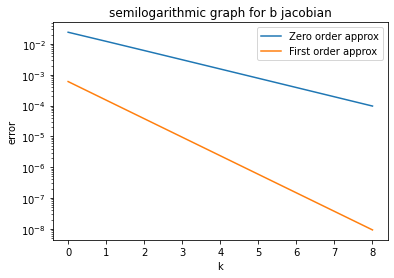

print semilogarithmic graph for x jacobian


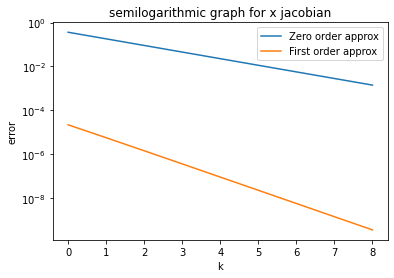

print semilogarithmic graph for w jacobian


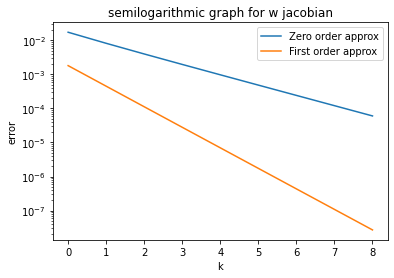

print semilogarithmic graph for w2 jacobian


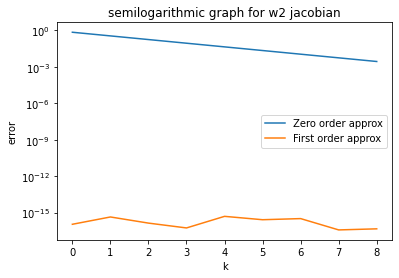

In [ ]:
n, m = 8, 32
nexti = n
x = np.random.randn(n, m)
w = np.random.randn(nexti, n)
b = np.random.rand(w.shape[0], 1)
v = np.random.rand(nexti, m)
w2 = np.random.randn(nexti, n)
w = w / np.linalg.norm(w)
b = b / np.linalg.norm(b)
v = v / np.linalg.norm(v)
w2 = w2 / np.linalg.norm(w2)

test_jacobian(x, w, b, v, w2=w2)

We see the jacobian gradients act the way expected, and w2 is not affected by the gradient, thus remains with the same order of magnitude with no relation to epsk.

Training on: SwissRollData
layer_0: w: (15, 2), b:(15, 1)
layer_1: w: (15, 15), b:(15, 1)
layer_2: w: (2, 15), b:(2, 1)
epoch 1: acc_train = 0.62315, acc_val = 0.6208, loss_val = 0.6751342096452803, train_loss = 0.6677612443652108
epoch 26: acc_train = 0.8818, acc_val = 0.8834, loss_val = 0.2848935169650663, train_loss = 0.28508407231717714
epoch 51: acc_train = 0.9553, acc_val = 0.9568, loss_val = 0.18228730283771608, train_loss = 0.17818315092166961
epoch 76: acc_train = 0.95495, acc_val = 0.9524, loss_val = 0.1845848427959403, train_loss = 0.1790619574661184
epoch 101: acc_train = 0.96385, acc_val = 0.964, loss_val = 0.15433741697027212, train_loss = 0.14892554614576364


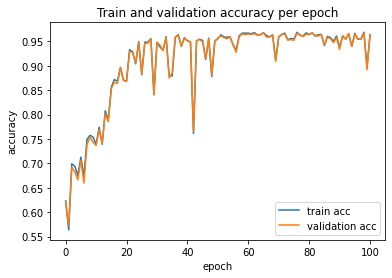

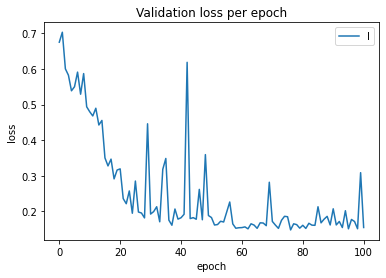

In [ ]:
print(f'Training on: SwissRollData')
arch, all_data = create_arch('SwissRollData', True)
model = Model(layer_dict=arch, batch_size=32, epochs=101, lr=0.1, is_resnet=True)
model.train(all_data)

Training on: GMMData
layer_0: w: (15, 5), b:(15, 1)
layer_1: w: (15, 15), b:(15, 1)
layer_2: w: (5, 15), b:(5, 1)
epoch 1: acc_train = 0.84804, acc_val = 0.84688, loss_val = 0.5507878437964323, train_loss = 0.5383767333932913
epoch 26: acc_train = 0.9492, acc_val = 0.94784, loss_val = 0.2440978776236229, train_loss = 0.22541309606497378
epoch 51: acc_train = 0.95812, acc_val = 0.95664, loss_val = 0.21076325359862935, train_loss = 0.1984092494186332
epoch 76: acc_train = 0.95992, acc_val = 0.95872, loss_val = 0.19916686845716708, train_loss = 0.18792411018377833
epoch 101: acc_train = 0.96272, acc_val = 0.96352, loss_val = 0.19257877437609427, train_loss = 0.1792902934451241


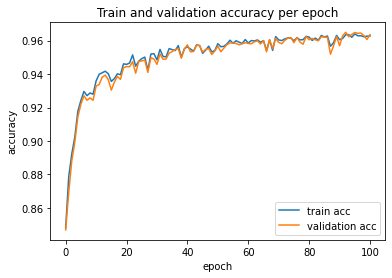

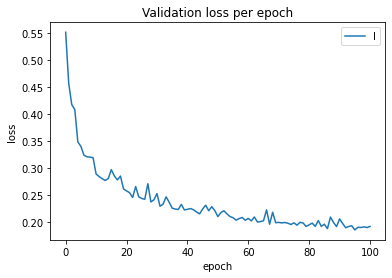

In [ ]:
print(f'Training on: GMMData')
arch, all_data = create_arch('GMMData', True)
model = Model(layer_dict=arch, batch_size=32, epochs=101, lr=0.1, is_resnet=True)
model.train(all_data)

Training on: PeaksData
layer_0: w: (15, 2), b:(15, 1)
layer_1: w: (15, 15), b:(15, 1)
layer_2: w: (5, 15), b:(5, 1)
epoch 1: acc_train = 0.73556, acc_val = 0.728, loss_val = 0.7819933720445444, train_loss = 0.769163653181907
epoch 26: acc_train = 0.90204, acc_val = 0.90032, loss_val = 0.34002102243221416, train_loss = 0.33010887182780696
epoch 51: acc_train = 0.9194, acc_val = 0.91376, loss_val = 0.30703853296481065, train_loss = 0.29325771088850566
epoch 76: acc_train = 0.92624, acc_val = 0.92352, loss_val = 0.29151192602196974, train_loss = 0.28079578828124885
epoch 101: acc_train = 0.92256, acc_val = 0.9216, loss_val = 0.29498507712044914, train_loss = 0.2819763612797929


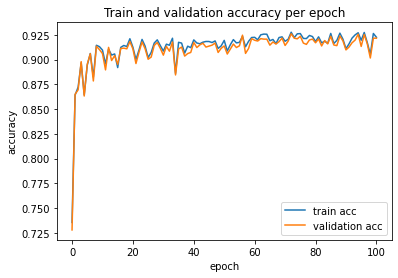

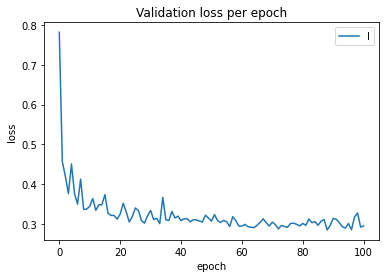

In [ ]:
print(f'Training on: PeaksData')
arch, all_data = create_arch('PeaksData', True)
model = Model(layer_dict=arch, batch_size=32, epochs=101, lr=0.1, is_resnet=True)
model.train(all_data)

Note: We can assume that the resnet achieves an improvment on the dataset with the same lr and bs, maybe due to the nature of this network (i.e. learning the difference from the signal)

### 2.2.3. Now, after we’ve verified that all the individual parts are OK, we will examine that their combination together in the whole network also works—the forward pass and the backward pass of the network with L layers (L is a parameter). See that the gradient of the whole network (softmax + layers) passes the gradient test.

In [ ]:
def _set_weights(nn, ws):
    for layer, (w, b) in zip(nn.layers, ws):
        nn.layers[layer].w = w
        nn.layers[layer].b = b
    return nn

def test_grad_softmax_nn(nn, x, y, iters=10, eps=0.1, title=None):
    weights = [nn.layers[layer].w for layer in nn.layers]
    biases = [nn.layers[layer].b for layer in nn.layers]
    w_shapes = [w.shape for w in weights]
    b_shapes = [b.shape for b in biases]
    dws = [d / np.linalg.norm(d) for d in (np.random.rand(w[0], w[1]) for w in w_shapes)]
    dbs = [np.expand_dims(np.ones(b[0]), axis=1) for b in b_shapes]

    preds = nn.forward(x)
    f0 = softmax_loss(preds, y)
    nn.backward(preds, y)

    gw = np.concatenate([np.ravel(nn.layers[layer].dw) for layer in nn.layers], axis=0)
    gb = np.concatenate([np.ravel(nn.layers[layer].db) for layer in nn.layers], axis=0)
    dw_grad = np.concatenate([np.ravel(d) for d in dws]) @ gw
    db_grad = np.concatenate([np.ravel(d) for d in dbs]) @ gb
    y0, y1 = np.zeros(iters), np.zeros(iters)
    df = pd.DataFrame(columns=["Error order 1", "Error order 2"])
    cprint("k\t error order 1 \t\t\t error order 2", 'green')
    for k in range(iters):
        epsk = eps * (0.2 ** k)
        nn = _set_weights(nn, [(w + epsk * dw, b + epsk * db) for w, b, dw, db in zip(weights, biases, dws, dbs)])
        out = nn.forward(x)
        fk = softmax_loss(out, y)
        y0[k] = np.abs(fk - f0)
        y1[k] = np.abs(fk - f0 - epsk * dw_grad - epsk * db_grad)
        print(k, "\t", y0[k], "\t", y1[k])
        s = pd.Series([y0[k], y1[k]], index=df.columns.to_list())
        df = df.append(s, ignore_index=True)
    df.astype('string').to_csv('nn_grad_softmax_error_by_orders_nn.csv')
    plot_semilogy([y0, y1], title=title)

In [ ]:
name = 'SwissRollData'
data = datasets[name]
all_data = (data['Yt'].T, data['Yv'].T, data['Ct'].T, data['Cv'].T)

The following graph will show the gradient test for the linear fully connected layers Neural Network, with respect to w and b.

layer_0: w: (8, 2), b:(8, 1)
layer_1: w: (9, 8), b:(9, 1)
layer_2: w: (2, 9), b:(2, 1)
k	 error order 1 			 error order 2
0 	 0.10358231030075182 	 0.009738425263183442
1 	 0.019180098107071775 	 0.0004113210995580936
2 	 0.0037725696215160642 	 1.8814220013328112e-05
3 	 0.0007512986614715 	 5.475811709527729e-07
4 	 0.0001502270795714633 	 7.686351135386955e-08
5 	 3.003080169761141e-05 	 7.584855895147332e-10
6 	 6.006041086248359e-06 	 3.244384398029559e-11
7 	 1.2012030261576712e-06 	 1.2976767953587812e-12
8 	 2.402403975754197e-07 	 5.187924452469114e-14
9 	 4.8048071077388954e-08 	 1.9381539164635494e-15


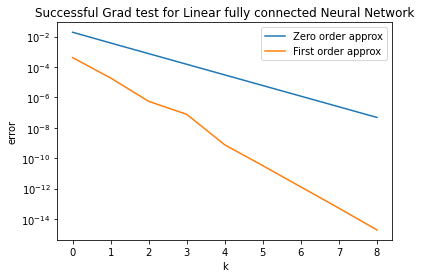

In [ ]:
arch, all_data = create_arch('SwissRollData', False)
model = Model(layer_dict=arch, batch_size=32, epochs=101, lr=0.1, is_resnet=False)
test_grad_softmax_nn(model, data['Yv'],  data['Cv'], title="Successful Grad test for Linear fully connected Neural Network")

The following graph will show the gradient test for the residual fully connected Neural Network, with respect to the parameters.

layer_0: w: (15, 2), b:(15, 1)
layer_1: w: (15, 15), b:(15, 1)
layer_2: w: (2, 15), b:(2, 1)
k	 error order 1 			 error order 2
0 	 1.2121190399952724 	 0.04734918731685922
1 	 0.2512043419822696 	 0.0006893034801567222
2 	 0.05047034390791083 	 9.161481542555722e-05
3 	 0.010074602218114848 	 1.1436003822060808e-06
4 	 0.002014801901530916 	 3.472621684947469e-07
5 	 0.00040303364063731806 	 3.807897435846759e-09
6 	 8.06061188569629e-05 	 1.5230898644082516e-10
7 	 1.6121199401197828e-05 	 6.091602540453248e-12
8 	 3.224238906085475e-06 	 2.4416641702473905e-13
9 	 6.448477414267018e-07 	 9.042890075327257e-15


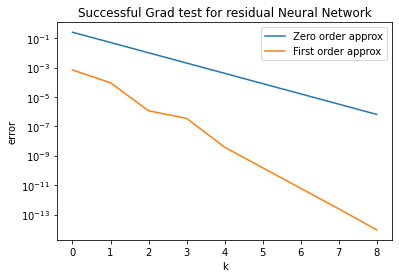

In [ ]:
arch, all_data = create_arch('SwissRollData', True)
model = Model(layer_dict=arch, batch_size=32, epochs=101, lr=0.1, is_resnet=True)
test_grad_softmax_nn(model, data['Yv'],  data['Cv'],title="Successful Grad test for residual Neural Network")

### 2.2.4. Repeat section 2.1.3 for the entire network. Try a few network lengths and see how this influences the performance. Write your conclusions and demonstrate them.

Let us see a couple of runs and see how different changes impact our network. of course we will do ablation studies to understand the impact of each part.

First of all, Let us see how deeper network impact the network. We will add aditional (more of the same) same size layers:

layer_0: w: (8, 2), b:(8, 1)
layer_1: w: (10, 8), b:(10, 1)
layer_2: w: (5, 10), b:(5, 1)
epoch 1: acc_train = 0.68016, acc_val = 0.676, loss_val = 1.0041259990787106, train_loss = 0.9766845641591294
epoch 26: acc_train = 0.81232, acc_val = 0.80928, loss_val = 0.6419495267868642, train_loss = 0.6149639752160093
epoch 51: acc_train = 0.83804, acc_val = 0.83472, loss_val = 0.60927166146154, train_loss = 0.5827590132936942
epoch 76: acc_train = 0.84008, acc_val = 0.83536, loss_val = 0.5843528730090773, train_loss = 0.5579943800051705
epoch 101: acc_train = 0.8434, acc_val = 0.83536, loss_val = 0.559744338270449, train_loss = 0.5348865815254263


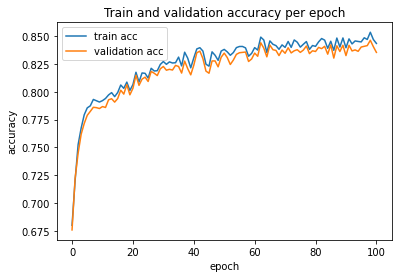

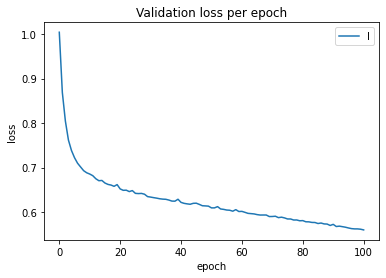

layer_0: w: (8, 2), b:(8, 1)
layer_1: w: (10, 8), b:(10, 1)
layer_2: w: (10, 10), b:(10, 1)
layer_3: w: (5, 10), b:(5, 1)
epoch 1: acc_train = 0.52312, acc_val = 0.52256, loss_val = 2.3706448880259834, train_loss = 2.356937114590699
epoch 26: acc_train = 0.81336, acc_val = 0.81456, loss_val = 0.612862175646267, train_loss = 0.5905628542259553
epoch 51: acc_train = 0.86696, acc_val = 0.86304, loss_val = 0.5142558585902787, train_loss = 0.4887815633582533
epoch 76: acc_train = 0.8702, acc_val = 0.86928, loss_val = 0.48361268605223895, train_loss = 0.459379501715438
epoch 101: acc_train = 0.87324, acc_val = 0.86768, loss_val = 0.46019876543580895, train_loss = 0.43632299088818755


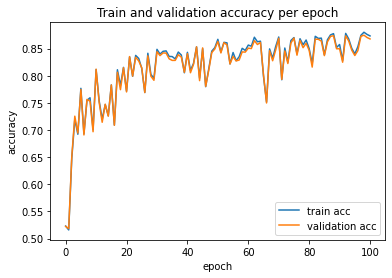

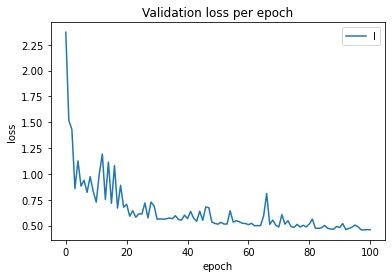

layer_0: w: (8, 2), b:(8, 1)
layer_1: w: (10, 8), b:(10, 1)
layer_2: w: (10, 10), b:(10, 1)
layer_3: w: (10, 10), b:(10, 1)
layer_4: w: (5, 10), b:(5, 1)
epoch 1: acc_train = 0.51724, acc_val = 0.51152, loss_val = 5.338481839243202, train_loss = 5.287765918735714
epoch 26: acc_train = 0.842, acc_val = 0.83776, loss_val = 0.5529214465919213, train_loss = 0.5417483433085896
epoch 51: acc_train = 0.83492, acc_val = 0.83056, loss_val = 0.5335069476003688, train_loss = 0.5257459432648797
epoch 76: acc_train = 0.86824, acc_val = 0.86592, loss_val = 0.47713214414438115, train_loss = 0.4704806759800398
epoch 101: acc_train = 0.87584, acc_val = 0.87328, loss_val = 0.4525755809919708, train_loss = 0.4431662247333971


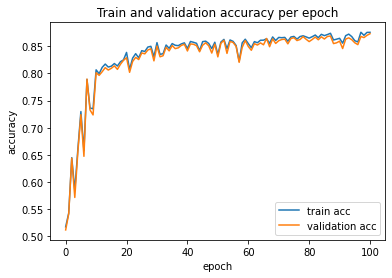

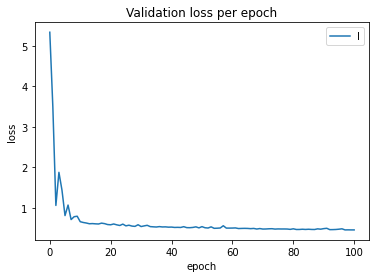

In [ ]:
name = 'PeaksData'
data = datasets[name]
all_data = (data['Yt'].T, data['Yv'].T, data['Ct'].T, data['Cv'].T)
input_shape = data['Yt'].shape[0]
output_shape = data['Ct'].shape[0]

bs = 128
lr = 0.05
arch = [{"input_dim": input_shape, "output_dim": 8, "activation": "relu"},
        {"input_dim": 8, "output_dim":10, "activation": "relu"},
        {"input_dim": 10, "output_dim": output_shape, "activation": "softmax"}]
model = Model(layer_dict=arch, batch_size=bs, epochs=101, lr=lr, is_resnet=False)
model.train(all_data)
arch2 = [{"input_dim": input_shape, "output_dim": 8, "activation": "relu"},
        {"input_dim": 8, "output_dim": 10, "activation": "relu"},
         {"input_dim": 10, "output_dim": 10, "activation": "relu"},
        {"input_dim": 10, "output_dim": output_shape, "activation": "softmax"}]
model = Model(layer_dict=arch2, batch_size=bs, epochs=101, lr=lr, is_resnet=False)
model.train(all_data)
arch3 = [{"input_dim": input_shape, "output_dim": 8, "activation": "relu"},
        {"input_dim": 8, "output_dim": 10, "activation": "relu"},
        {"input_dim": 10, "output_dim": 10, "activation": "relu"},
        {"input_dim": 10, "output_dim": 10, "activation": "relu"},
        {"input_dim": 10, "output_dim": output_shape, "activation": "softmax"}]
model = Model(layer_dict=arch3, batch_size=bs, epochs=101, lr=lr, is_resnet=False)
model.train(all_data)

We can see in these small examples that using deeper networks can help us reduce loss and converge faster, but we also can reach a certain point where only adding layers don't improve results but increase train time. In theory, in much bigger examples, it can also degregade the accuracy.

Now let us see what happens if we expand our nn layer sizes - meaning more neurons per layer:

layer_0: w: (10, 5), b:(10, 1)
layer_1: w: (10, 10), b:(10, 1)
layer_2: w: (5, 10), b:(5, 1)
epoch 1: acc_train = 0.31032, acc_val = 0.3064, loss_val = 1.7361991027251653, train_loss = 1.7429323097148701
epoch 26: acc_train = 0.66704, acc_val = 0.67168, loss_val = 0.8514050385146739, train_loss = 0.8551087076595977
epoch 51: acc_train = 0.77604, acc_val = 0.77488, loss_val = 0.6602882930923887, train_loss = 0.6604327873691193
epoch 76: acc_train = 0.84008, acc_val = 0.84144, loss_val = 0.523293350467028, train_loss = 0.520142490507733
epoch 101: acc_train = 0.85768, acc_val = 0.86016, loss_val = 0.45487839551200976, train_loss = 0.4522314586646377


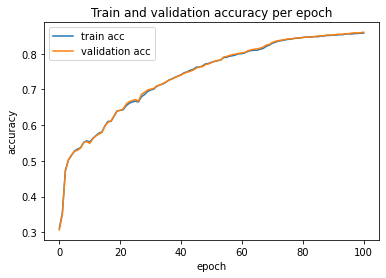

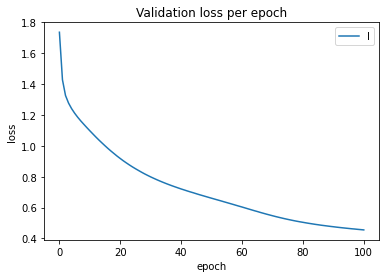

layer_0: w: (45, 5), b:(45, 1)
layer_1: w: (45, 45), b:(45, 1)
layer_2: w: (5, 45), b:(5, 1)
epoch 1: acc_train = 0.6174, acc_val = 0.61696, loss_val = 1.1045776432172143, train_loss = 1.107851896424279
epoch 26: acc_train = 0.9424, acc_val = 0.94112, loss_val = 0.2548196183408955, train_loss = 0.24691205953502146
epoch 51: acc_train = 0.95228, acc_val = 0.952, loss_val = 0.22319154796296573, train_loss = 0.21696861906700565
epoch 76: acc_train = 0.95632, acc_val = 0.95456, loss_val = 0.20821705420445008, train_loss = 0.20270370495794554
epoch 101: acc_train = 0.95856, acc_val = 0.95824, loss_val = 0.198787648049346, train_loss = 0.19351912105522973


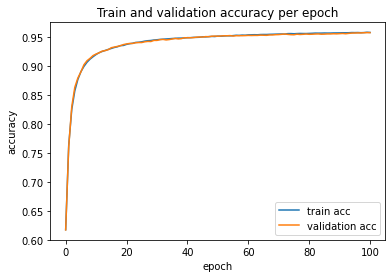

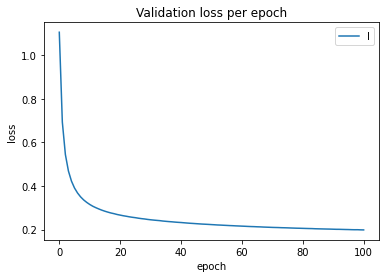

layer_0: w: (200, 5), b:(200, 1)
layer_1: w: (200, 200), b:(200, 1)
layer_2: w: (5, 200), b:(5, 1)
epoch 1: acc_train = 0.7434, acc_val = 0.74336, loss_val = 1.2864794941701398, train_loss = 1.317460826399281
epoch 26: acc_train = 0.952, acc_val = 0.94896, loss_val = 0.3134588308709256, train_loss = 0.2860257676591609
epoch 51: acc_train = 0.9598, acc_val = 0.95696, loss_val = 0.2672436133105952, train_loss = 0.2288378928630315
epoch 76: acc_train = 0.96344, acc_val = 0.95872, loss_val = 0.24205210016261258, train_loss = 0.19959345176339896
epoch 101: acc_train = 0.9656, acc_val = 0.96016, loss_val = 0.22745134503021416, train_loss = 0.18094158256856846


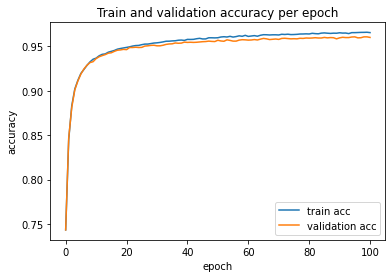

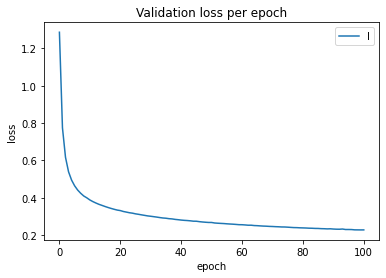

In [ ]:
name = 'GMMData'
data = datasets[name]
all_data = (data['Yt'].T, data['Yv'].T, data['Ct'].T, data['Cv'].T)
input_shape = data['Yt'].shape[0]
output_shape = data['Ct'].shape[0]
bs = 32
lr = 0.01
arch = [{"input_dim": input_shape, "output_dim": 10, "activation": "tanh"},
        {"input_dim": 10, "output_dim":10, "activation": "tanh"},
        {"input_dim": 10, "output_dim": output_shape, "activation": "softmax"}]
model = Model(layer_dict=arch, batch_size=bs, epochs=101, lr=lr)
model.train(all_data)
arch = [{"input_dim": input_shape, "output_dim": 45, "activation": "tanh"},
        {"input_dim": 45, "output_dim":45, "activation": "tanh"},
        {"input_dim": 45, "output_dim": output_shape, "activation": "softmax"}]
model = Model(layer_dict=arch, batch_size=bs, epochs=101, lr=lr)
model.train(all_data)
arch = [{"input_dim": input_shape, "output_dim": 200, "activation": "tanh"},
        {"input_dim": 200, "output_dim":200, "activation": "tanh"},
        {"input_dim": 200, "output_dim": output_shape, "activation": "softmax"}]
model = Model(layer_dict=arch, batch_size=bs, epochs=101, lr=lr)
model.train(all_data)

So here we can also see that increasing the number of neurons per layer can help us improve accuracy and converge faster, but beacuse of the toy datasets in some point we reach "saturation" where the acc doesn't improve, and the run time increases.

How about doing changes in learning rates?

training with lr = 5 and bs = 64
layer_0: w: (15, 5), b:(15, 1)
layer_1: w: (15, 15), b:(15, 1)
layer_2: w: (5, 15), b:(5, 1)
epoch 1: acc_train = 0.88236, acc_val = 0.88096, loss_val = 0.4433480262729512, train_loss = 0.44639410801781143
epoch 26: acc_train = 0.9648, acc_val = 0.96288, loss_val = 0.1745455733942398, train_loss = 0.1703863133708112
epoch 51: acc_train = 0.96708, acc_val = 0.96624, loss_val = 0.16478070434196507, train_loss = 0.16073569543151792
epoch 76: acc_train = 0.96876, acc_val = 0.96768, loss_val = 0.16199511894532567, train_loss = 0.15637763809515162
epoch 101: acc_train = 0.96088, acc_val = 0.95872, loss_val = 0.17634926786467775, train_loss = 0.17029976659966792


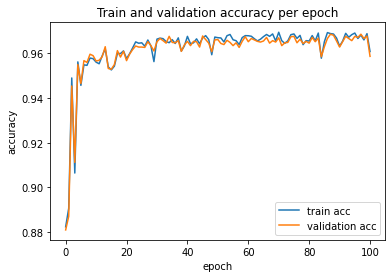

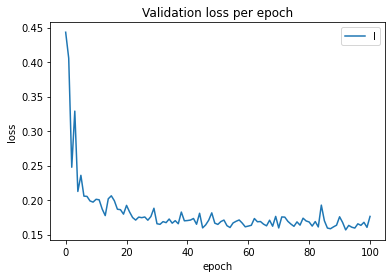

training with lr = 2 and bs = 64
layer_0: w: (15, 5), b:(15, 1)
layer_1: w: (15, 15), b:(15, 1)
layer_2: w: (5, 15), b:(5, 1)
epoch 1: acc_train = 0.87204, acc_val = 0.86832, loss_val = 0.5565924509717534, train_loss = 0.5719972698911895
epoch 26: acc_train = 0.95844, acc_val = 0.96, loss_val = 0.1980433031478907, train_loss = 0.19833728041154258
epoch 51: acc_train = 0.96132, acc_val = 0.96256, loss_val = 0.18243245755236162, train_loss = 0.18105139990609925
epoch 76: acc_train = 0.9634, acc_val = 0.96624, loss_val = 0.17607806215083308, train_loss = 0.1755932580417725
epoch 101: acc_train = 0.96636, acc_val = 0.96816, loss_val = 0.16322471298936322, train_loss = 0.16069487162122897


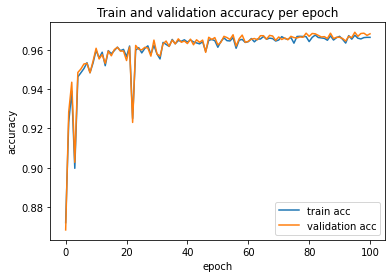

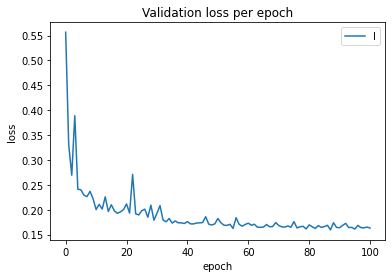

training with lr = 1 and bs = 64
layer_0: w: (15, 5), b:(15, 1)
layer_1: w: (15, 15), b:(15, 1)
layer_2: w: (5, 15), b:(5, 1)
epoch 1: acc_train = 0.88712, acc_val = 0.88752, loss_val = 0.42871873627301776, train_loss = 0.4502765698473956
epoch 26: acc_train = 0.95708, acc_val = 0.9576, loss_val = 0.2030709335915318, train_loss = 0.20244510209323197
epoch 51: acc_train = 0.96024, acc_val = 0.95888, loss_val = 0.1868728068906441, train_loss = 0.1852962554461685
epoch 76: acc_train = 0.95848, acc_val = 0.9576, loss_val = 0.18902462103501022, train_loss = 0.18605221723837664
epoch 101: acc_train = 0.96388, acc_val = 0.96288, loss_val = 0.17683429340399393, train_loss = 0.171105047663378


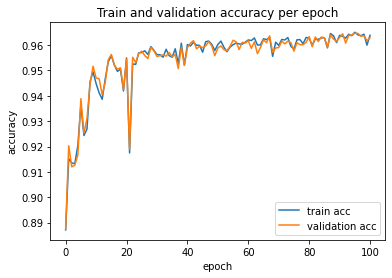

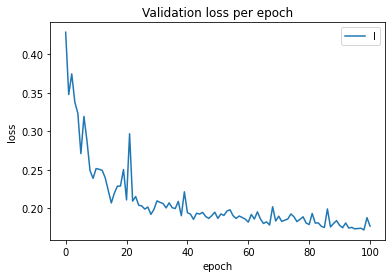

training with lr = 0.5 and bs = 64
layer_0: w: (15, 5), b:(15, 1)
layer_1: w: (15, 15), b:(15, 1)
layer_2: w: (5, 15), b:(5, 1)
epoch 1: acc_train = 0.8134, acc_val = 0.81104, loss_val = 0.6765393490645624, train_loss = 0.6809481511257086
epoch 26: acc_train = 0.95484, acc_val = 0.95632, loss_val = 0.20989628237347688, train_loss = 0.21005391358475392
epoch 51: acc_train = 0.95792, acc_val = 0.95776, loss_val = 0.20215009923532168, train_loss = 0.19960361965787513
epoch 76: acc_train = 0.96116, acc_val = 0.96144, loss_val = 0.18804657347396078, train_loss = 0.18452959760473975
epoch 101: acc_train = 0.96296, acc_val = 0.96368, loss_val = 0.1857034560565641, train_loss = 0.17762192292062173


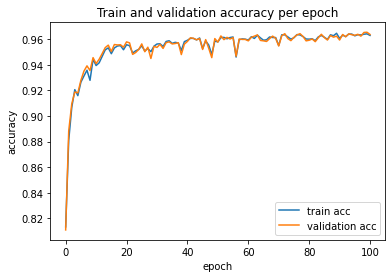

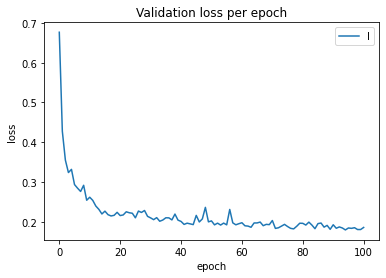

In [ ]:
name = 'GMMData'
data = datasets[name]
all_data = (data['Yt'].T, data['Yv'].T, data['Ct'].T, data['Cv'].T)
input_shape = data['Yt'].shape[0]
output_shape = data['Ct'].shape[0]
bs = 64
for lr in [5, 2, 1, 0.5]:
  cprint(f'training with lr = {lr} and bs = {bs}', 'blue')
  arch = [{"input_dim": input_shape, "output_dim": 15, "activation": "tanh"},
          {"input_dim": 15, "output_dim":15, "activation": "tanh"},
          {"input_dim": 15, "output_dim": output_shape, "activation": "softmax"}]
  model = Model(layer_dict=arch, batch_size=bs, epochs=101, lr=lr, is_resnet=True)
  model.train(all_data)

training with lr = 0.1 and bs = 64
layer_0: w: (15, 5), b:(15, 1)
layer_1: w: (15, 15), b:(15, 1)
layer_2: w: (5, 15), b:(5, 1)
epoch 1: acc_train = 0.7044, acc_val = 0.70192, loss_val = 0.7982290961648311, train_loss = 0.8097178223236392
epoch 26: acc_train = 0.92264, acc_val = 0.92848, loss_val = 0.30690170255792293, train_loss = 0.30901082960413334
epoch 51: acc_train = 0.94184, acc_val = 0.9472, loss_val = 0.25918588896312456, train_loss = 0.2543454962890908
epoch 76: acc_train = 0.94876, acc_val = 0.94944, loss_val = 0.24101205172644952, train_loss = 0.23116483613629468
epoch 101: acc_train = 0.95016, acc_val = 0.95024, loss_val = 0.23400438685266922, train_loss = 0.2223651532731328


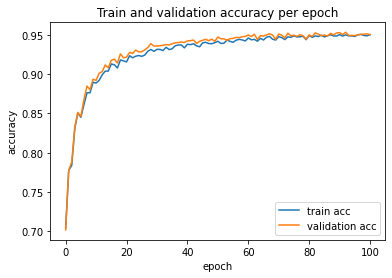

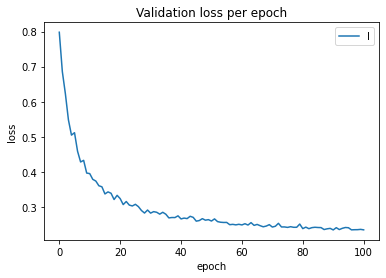

training with lr = 0.05 and bs = 64
layer_0: w: (15, 5), b:(15, 1)
layer_1: w: (15, 15), b:(15, 1)
layer_2: w: (5, 15), b:(5, 1)
epoch 1: acc_train = 0.638, acc_val = 0.63424, loss_val = 0.9270210353692453, train_loss = 0.9339703812328293
epoch 26: acc_train = 0.90196, acc_val = 0.90784, loss_val = 0.3631913270729485, train_loss = 0.37305816653017454
epoch 51: acc_train = 0.92424, acc_val = 0.9304, loss_val = 0.2998567442029063, train_loss = 0.3024914629486006
epoch 76: acc_train = 0.9356, acc_val = 0.93968, loss_val = 0.27001766614826167, train_loss = 0.26820779021493374
epoch 101: acc_train = 0.94136, acc_val = 0.94576, loss_val = 0.2568624049622232, train_loss = 0.2513640839968809


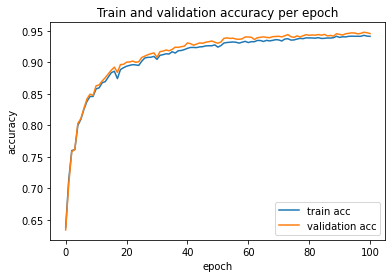

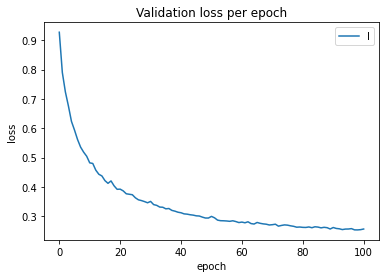

training with lr = 0.01 and bs = 64
layer_0: w: (15, 5), b:(15, 1)
layer_1: w: (15, 15), b:(15, 1)
layer_2: w: (5, 15), b:(5, 1)
epoch 1: acc_train = 0.42844, acc_val = 0.42432, loss_val = 1.8999020540607265, train_loss = 1.8919025151290572
epoch 26: acc_train = 0.80656, acc_val = 0.80944, loss_val = 0.6113593995095178, train_loss = 0.6235353981281634
epoch 51: acc_train = 0.85612, acc_val = 0.8584, loss_val = 0.48855946898004143, train_loss = 0.5003740097916571
epoch 76: acc_train = 0.87852, acc_val = 0.884, loss_val = 0.42821826436191773, train_loss = 0.44012893256882973
epoch 101: acc_train = 0.8942, acc_val = 0.89984, loss_val = 0.3905762398797276, train_loss = 0.40173790265389925


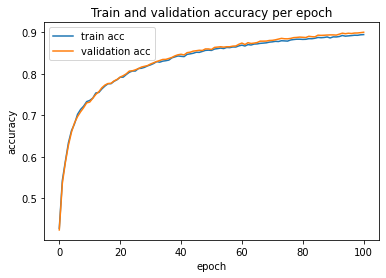

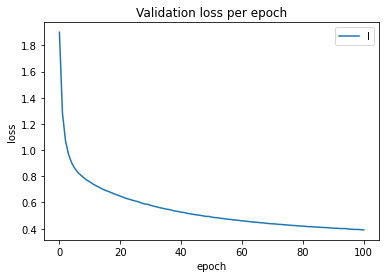

training with lr = 0.005 and bs = 64
layer_0: w: (15, 5), b:(15, 1)
layer_1: w: (15, 15), b:(15, 1)
layer_2: w: (5, 15), b:(5, 1)
epoch 1: acc_train = 0.36888, acc_val = 0.36688, loss_val = 3.1637760472320786, train_loss = 3.1504687560749662
epoch 26: acc_train = 0.75284, acc_val = 0.74816, loss_val = 0.7281185230907168, train_loss = 0.7406666239185932
epoch 51: acc_train = 0.80556, acc_val = 0.80816, loss_val = 0.6125769685497918, train_loss = 0.6257997489441715
epoch 76: acc_train = 0.83788, acc_val = 0.84304, loss_val = 0.5389428289602248, train_loss = 0.5519358280219787
epoch 101: acc_train = 0.8562, acc_val = 0.85904, loss_val = 0.4898887371569216, train_loss = 0.5023712897981055


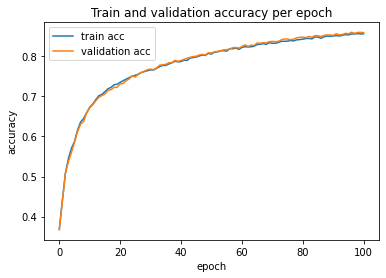

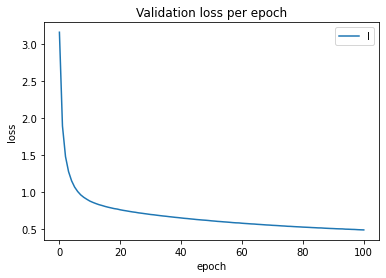

In [ ]:
name = 'GMMData'
data = datasets[name]
all_data = (data['Yt'].T, data['Yv'].T, data['Ct'].T, data['Cv'].T)
input_shape = data['Yt'].shape[0]
output_shape = data['Ct'].shape[0]
bs = 64
for lr in [0.1, 0.05, 0.01, 0.005]:
  cprint(f'training with lr = {lr} and bs = {bs}', 'blue')
  arch = [{"input_dim": input_shape, "output_dim": 15, "activation": "tanh"},
          {"input_dim": 15, "output_dim":15, "activation": "tanh"},
          {"input_dim": 15, "output_dim": output_shape, "activation": "softmax"}]
  model = Model(layer_dict=arch, batch_size=bs, epochs=101, lr=lr, is_resnet=True)
  model.train(all_data)

We can see that the optimal lr between the one tested, for this  (architecture, bs, epochs) combination tuple is 2 (by CE loss, 6 by val. accuracy) and other lrs cause worse (or even much worse) results, due to not reaching a smaller local minima.

### 2.2.5. Repeat the previous section, only now use only 200 data points for training (sample them randomly). How do the results change, if at all?

Training on: GMMData dataset with only 200 samples
layer_0: w: (8, 5), b:(8, 1)
layer_1: w: (8, 8), b:(8, 1)
layer_2: w: (5, 8), b:(5, 1)
epoch 1: acc_train = 0.38056, acc_val = 0.38608, loss_val = 2.4947181801481086, train_loss = 2.53019469734992
epoch 26: acc_train = 0.76192, acc_val = 0.76944, loss_val = 0.6870629383960603, train_loss = 0.7002066385488108
epoch 51: acc_train = 0.82376, acc_val = 0.8248, loss_val = 0.5333684825780292, train_loss = 0.5439120379005596
epoch 76: acc_train = 0.85184, acc_val = 0.84768, loss_val = 0.4702795322699954, train_loss = 0.48132511742616046
epoch 101: acc_train = 0.87048, acc_val = 0.8656, loss_val = 0.4368110502699469, train_loss = 0.44869187713807335
epoch 126: acc_train = 0.87764, acc_val = 0.87568, loss_val = 0.40966314779831586, train_loss = 0.4213817331504909
epoch 151: acc_train = 0.88776, acc_val = 0.88592, loss_val = 0.3862757570304094, train_loss = 0.4014771777686448


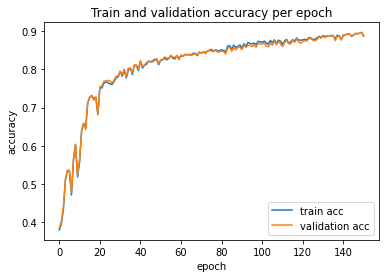

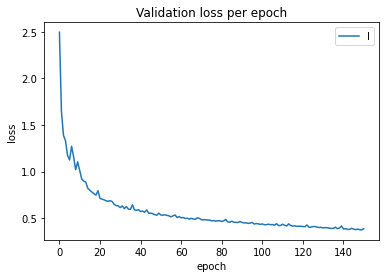

choosing 200 samples...
layer_0: w: (8, 5), b:(8, 1)
layer_1: w: (8, 8), b:(8, 1)
layer_2: w: (5, 8), b:(5, 1)
epoch 1: acc_train = 0.11, acc_val = 0.152, loss_val = 6.1455188018345694, train_loss = 5.726440160389261
epoch 26: acc_train = 0.37, acc_val = 0.3368, loss_val = 2.081821649812266, train_loss = 2.0404915922512696
epoch 51: acc_train = 0.395, acc_val = 0.3672, loss_val = 1.7054989482780727, train_loss = 1.7161266667708281
epoch 76: acc_train = 0.4, acc_val = 0.3664, loss_val = 1.5920899452079162, train_loss = 1.594510322670953
epoch 101: acc_train = 0.38, acc_val = 0.36208, loss_val = 1.5040112349750399, train_loss = 1.5193209337405578
epoch 126: acc_train = 0.425, acc_val = 0.40592, loss_val = 1.4631906415173779, train_loss = 1.4725509930359324
epoch 151: acc_train = 0.42, acc_val = 0.37792, loss_val = 1.430650293899858, train_loss = 1.4294279467246087


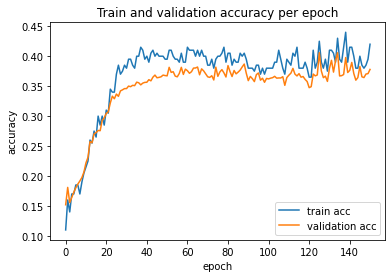

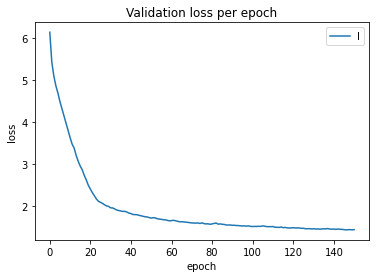

In [ ]:
n_samples = 200
name = 'GMMData'
dataset = datasets[name]
all_data = (dataset['Yt'].T, dataset['Yv'].T, dataset['Ct'].T, dataset['Cv'].T)
input_shape = dataset['Yt'].shape[0]
output_shape = dataset['Ct'].shape[0]

print(f'Training on: {name} dataset with only {n_samples} samples')

arch = [{"input_dim": input_shape, "output_dim": 8, "activation": "relu"},
        {"input_dim": 8, "output_dim" : 8, "activation": "relu"},
        {"input_dim": 8, "output_dim": output_shape, "activation": "softmax"}]

bs = 128
lr = 0.1
model = Model(layer_dict=arch, batch_size=128, epochs=151, lr=lr, is_resnet=True)
model.train(all_data)

print(f'choosing {n_samples} samples...')
sample = np.random.randint(dataset['Yt'].shape[1], size=n_samples)
small_data = (dataset['Yt'].T[sample, :], dataset['Yv'].T, dataset['Ct'].T[sample, :], dataset['Cv'].T)
model = Model(layer_dict=arch, batch_size=bs, epochs=151, lr=lr, is_resnet=False)
model.train(small_data)

As you can see, the decent in loss is much worse because of orders of magnitude less examples to learn from in the train set.

Training on: SwissRollData dataset with only 200 samples
layer_0: w: (10, 2), b:(10, 1)
layer_1: w: (20, 10), b:(20, 1)
layer_2: w: (2, 20), b:(2, 1)
epoch 1: acc_train = 0.542, acc_val = 0.5404, loss_val = 0.6551297756430272, train_loss = 0.6550675421096498
epoch 26: acc_train = 0.6719, acc_val = 0.6748, loss_val = 0.5459664962565531, train_loss = 0.5492606193870098
epoch 51: acc_train = 0.8073, acc_val = 0.8138, loss_val = 0.4230616188592238, train_loss = 0.42519011087444725
epoch 76: acc_train = 0.87305, acc_val = 0.8796, loss_val = 0.3113256101142738, train_loss = 0.3116326924848229
epoch 101: acc_train = 0.92735, acc_val = 0.9312, loss_val = 0.2436854255445411, train_loss = 0.2424248859302601


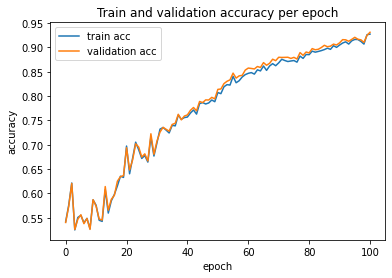

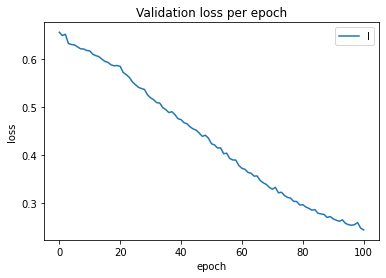

choosing 200 samples...
layer_0: w: (10, 2), b:(10, 1)
layer_1: w: (20, 10), b:(20, 1)
layer_2: w: (2, 20), b:(2, 1)
epoch 1: acc_train = 0.53, acc_val = 0.4896, loss_val = 1.8935306460822894, train_loss = 1.7465216559797003
epoch 26: acc_train = 0.54, acc_val = 0.5196, loss_val = 0.678182863714231, train_loss = 0.654207822695795
epoch 51: acc_train = 0.555, acc_val = 0.5364, loss_val = 0.6731148932459522, train_loss = 0.6457880664585632
epoch 76: acc_train = 0.525, acc_val = 0.5196, loss_val = 0.6679411099432834, train_loss = 0.6393319583350675
epoch 101: acc_train = 0.575, acc_val = 0.5518, loss_val = 0.6671161790447933, train_loss = 0.6329410270233601


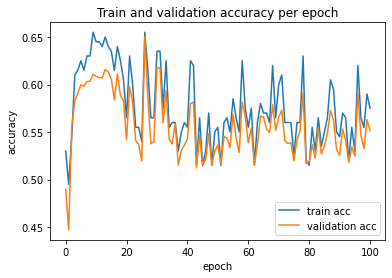

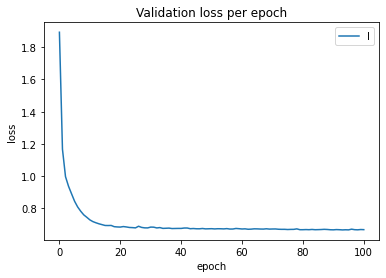

In [ ]:
n_samples = 200
name = 'SwissRollData'
dataset = datasets[name]
all_data = (dataset['Yt'].T, dataset['Yv'].T, dataset['Ct'].T, dataset['Cv'].T)
input_shape = dataset['Yt'].shape[0]
output_shape = dataset['Ct'].shape[0]

print(f'Training on: {name} dataset with only {n_samples} samples')

arch = [{"input_dim": input_shape, "output_dim": 10, "activation": "tanh"},
        {"input_dim": 10, "output_dim" : 20, "activation": "tanh"},
        {"input_dim": 20, "output_dim": output_shape, "activation": "softmax"}]

bs = 32
lr = 0.05
epochs = 101
model = Model(layer_dict=arch, batch_size=bs, epochs=epochs, lr=lr, is_resnet=False)
model.train(all_data)

print(f'choosing {n_samples} samples...')
sample = np.random.randint(dataset['Yt'].shape[1], size=n_samples)
small_data = (dataset['Yt'].T[sample, :], dataset['Yv'].T, dataset['Ct'].T[sample, :], dataset['Cv'].T)
model = Model(layer_dict=arch, batch_size=bs, epochs=epochs, lr=lr, is_resnet=False)
model.train(small_data)

As expected, also on the SwissRoll dataset, less examples lead to much poorer results cause of the lack of representation of validation data.